In [ ]:
# default_exp engine.microscope

In [ ]:
%load_ext autoreload
%autoreload 2

# Microscope model

> Definition of the classes and functions we use to generate recordings given network outputs or simulations

In [ ]:
#export
from decode_fish.imports import *
import torch.nn as nn
from decode_fish.funcs.utils import *
from torch.jit import script
from typing import Union, List
import torch.nn.functional as F
from decode_fish.funcs.plotting import *
# import elasticdeform.torch as etorch

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
class Microscope(nn.Module):
    """
    The Mircoscope module takes  5 vectors 'locations', 'x_os', 'y_os', 'z_os',
    'ints_3d' turns them into 3D data through the following steps:
    1) Apply continuous shifts to the PSF according to x_os, y_os, z_os
    2) Clamping the PSF (retaining only positive values)
    3) Normalize the PSF dividing it by it's max value
    6) Place point spread function according to locations  to
    generate 'x_sim'
    7) Multiplies x_sim with scale

    Args:
        psf (torch.nn.Module): Parametric PSF
        noise (torch.nn.Module): Camera noise model
        scale(float): Constant for scaling 
        
    Shape:
        -Input: locations: Tuple(torch.Tensor)
                x_os_val: (N_emitters,)
                y_os_val: (N_emitters,)
                z_os_val: (N_emitters,)
                ints_val: (N_emitters,C)
                output_shape: Shape Tuple(BS, C, H, W, D)

        -Output: xsim: (BS, C, H, W, D)
    """


    def __init__(self, psf: torch.nn.Module=None, noise: Union[torch.nn.Module, None]=None, scale: float = 10000., norm='max', sum_fac=1, psf_noise=0, slice_rec=False, ch_facs=None):

        super().__init__()
        self.psf = psf
        self.scale = scale
        self.noise = noise
        self.norm = norm
        
        self.theta = self.noise.theta_scale * self.noise.theta_par
        self.sum_fac = sum_fac
        
        self.psf_noise = psf_noise
        self.slice_rec = slice_rec
        self.psf_z_size = self.psf.psf_volume.shape[-3]
        self.n_cols = self.psf.n_cols
        
        self.register_parameter(name='channel_shifts', param=self.noise.channel_shifts)
        if ch_facs is None:
            self.register_parameter(name='channel_facs', param=torch.nn.Parameter(torch.ones(len(self.channel_shifts))))
        else: 
            self.register_parameter(name='channel_facs', param=torch.nn.Parameter(torch.tensor(ch_facs)))
        self.register_parameter(name='theta_par', param=self.noise.theta_par)
        self.register_parameter(name='psf_vol', param=self.psf.psf_volume)
        
    def add_psf_noise(self, psf_stack):

        '''Gaussian noise'''
        noise = torch.distributions.Normal(loc=0, scale=self.psf_noise).sample(psf_stack.shape).to(psf_stack.device)
        noise *= torch.sqrt(psf_stack)
#         noise *= torch.rand(len(psf_stack), device='cuda')[:,None,None,None,None]
        return psf_stack + noise
    
        '''Individual elastic deformation for each PSF (to slow)'''
#         psf_deformed = torch.cat([etorch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=self.psf_noise).sample([3,3,3,3]).to(psf_stack.device), order=3)[None] 
#                                   for psf in psf_stack[:,0]])
        '''Single deformation for all PSF in batch (kinda stupid)'''
#         psf_deformed = etorch.deform_grid(psf_stack[:,0], torch.distributions.Normal(loc=0, scale=self.psf_noise).sample([3,3,3,3]).to(psf_stack.device), axis=(1,2,3),order=3)
#         return psf_deformed[:,None]
        
    def forward(self, locations, x_os_val, y_os_val, z_os_val, i_val, output_shape, eval_=None, add_noise=False):
        
        if len(locations[0]):
            
            # We get the right channels when simulating, but for reconstruction we use ch = 0 for a single reconstructed image.
            ch_inds = i_val.nonzero(as_tuple=True)
            if ch_inds[1].max() > 0:
                shifts = self.channel_shifts - self.channel_shifts.mean(0)[None]

                x_os_ch = x_os_val[ch_inds[0]] + shifts[ch_inds[1], 0]
                y_os_ch = y_os_val[ch_inds[0]] + shifts[ch_inds[1], 1]
                z_os_ch = z_os_val[ch_inds[0]] + shifts[ch_inds[1], 2]
                
                locations = [l[ch_inds[0]] for l in locations]
                locations.insert(1,ch_inds[1])
                                
            if 'max' in self.norm:
                psf_norm = self.psf.psf_volume.max() 
            elif 'sum' in self.norm:
                psf_norm = torch.clamp_min(self.psf.psf_volume, 0).sum()/self.sum_fac
            else:
                psf_norm = 1
            # Apply continuous shift
            if self.slice_rec and self.psf_z_size > 1:
                z_os_ch = torch.clamp(z_os_ch,-0.49999,0.49999) + 0.5 # transform to [0,1]
                z_scaled = z_os_ch * (self.psf_z_size - 2) # [0, z_size]
                z_inds = (z_scaled//1).type(torch.cuda.LongTensor) + 1
                z_os = -(z_scaled%1.) + 0.5
                psf = self.psf(x_os_ch, y_os_ch, z_os, z_inds)
#                 psf = psf[torch.arange(len(z_os_ch)),:,z_inds][:,:,None]
            else:
                psf = self.psf(x_os_ch, y_os_ch, z_os_ch)
                
                
            torch.clamp_min_(psf,0)
            psf = psf/psf_norm
            
            if self.psf_noise and add_noise: 
                psf = self.add_psf_noise(psf)
                
            # applying intenseties

            tot_intensity = torch.clamp_min(i_val[ch_inds], 0)  * self.channel_facs[ch_inds[1]]

            psf = psf * tot_intensity[:,None,None,None,None]
            # place psf according to locations
#             return locations, psf, output_shape
            xsim = place_psf(locations, psf, output_shape)
            
            # scale (not learnable)
            xsim = self.scale * xsim
            if eval_:
                return xsim, psf
            return xsim
        
        else:
            
            return torch.zeros(output_shape).cuda()

In [ ]:
#export
def place_psf(locations, psf_volume, output_shape):
    """
    Places point spread functions (psf_volume) in to corresponding locations.

    Args:
        locations: tuple with the 5D voxel coordinates
        psf_volume: torch.Tensor
        output_shape: Shape Tuple(BS, C, H, W, D) 

    Returns:
        placed_psf: torch.Tensor with shape (BS, C, H, W, D)
    """

    batch, ch, z, y, x = locations
    placed_psf = _place_psf(psf_volume, batch, ch, z, y, x, torch.tensor(output_shape))
    assert placed_psf.shape == output_shape
    return placed_psf

In [ ]:
#export
@script
def _place_psf(psf_vols, b, ch, z, y, x, output_shape):
    '''jit function for placing PSFs
    1) This function will add padding to coordinates (z, y, x) (we need padding in order to place psf on the edges)
    afterwards we will just crop out to original shape
    2) Create empty tensor with paddings loc3d_like
    3) place each individual PSFs in to the corresponding cordinates in loc3d_like
    4) unpad to original output shape

    Args:
        psf_vols:   torch.Tensor
        b:        torch.Tensor
        c:        torch.Tensor
        h:        torch.Tensor
        w:        torch.Tensor
        d:        torch.Tensor
        szs:      torch.Tensor
        
    Shape:
        psf_vols: (Num_E, C, PSF_SZ_X, PSF_SZ_Y, PSF_SZ_Z)
        b:  (Num_E,)
        c:  (Num_E,)
        h:  (Num_E,)
        w:  (Num_E,)
        d:  (Num_E,)
        output_shape:  (BS, Frames, H, W, D)
        
    -Output: placed_psf: (BS, Frames, H, W, D)
        
    '''
    
    psf_b, psf_c, psf_h, psf_w, psf_d = psf_vols.shape
    pad_zyx = [psf_h//2, psf_w//2, psf_d//2]
    #add padding to z, y, x 
    
    z = z + pad_zyx[0]
    y = y + pad_zyx[1]
    x = x + pad_zyx[2]

    #create padded tensor (bs, frame, c, h, w) We will need pad_size * 2 since we are padding from both size
    loc3d_like = torch.zeros(output_shape[0], 
                             output_shape[1], 
                             output_shape[2] + 2*(pad_zyx[0]), 
                             output_shape[3] + 2*(pad_zyx[1]), 
                             output_shape[4] + 2*(pad_zyx[2])).to(x.device)
    
    if psf_c == 2:
        psf_ch_ind = torch.where(ch >= 8, 1, 0)
        psf_vols = psf_vols[torch.arange(len(psf_ch_ind)),psf_ch_ind]
    if output_shape[1] == 1:
        ch = torch.zeros_like(ch)
        
    psf_vols = psf_vols.reshape(-1, psf_h, psf_w, psf_d)
    
    # Take limit calculation out of the loop for 30% speed up
    z_l = z - pad_zyx[0]
    y_l = y - pad_zyx[1]
    x_l = x - pad_zyx[2]
    
    z_h = z + pad_zyx[0] + 1
    y_h = y + pad_zyx[1] + 1
    x_h = x + pad_zyx[2] + 1
    
    for idx in range(x.shape[0]):
        loc3d_like[b[idx], ch[idx],
        z_l[idx] : z_h[idx],
        y_l[idx] : y_h[idx],
        x_l[idx] : x_h[idx]] += psf_vols[idx]

    b_sz, ch_sz, h_sz, w_sz, d_sz = loc3d_like.shape

    # unpad to original size
    placed_psf = loc3d_like[:, :, pad_zyx[0]: h_sz - pad_zyx[0],
                                  pad_zyx[1]: w_sz - pad_zyx[1],
                                  pad_zyx[2]: d_sz - pad_zyx[2]]
    return placed_psf

In [ ]:
def swap_psf_vol(psf, vol):
    state_dict = psf.state_dict()
    for i in range(len(state_dict['psf_volume'])):
        state_dict['psf_volume'][i] = torch.cuda.FloatTensor(torch.Tensor(vol).cuda())**(i+1 + i*2)
    psf.load_state_dict(state_dict)
    return psf

def get_gaussian_psf(size_zyx, radii, pred_z, n_cols=1):
    if not pred_z:
        size_zyx[0] = 1
    psf = LinearInterpolatedPSF(size_zyx, device='cuda', n_cols=n_cols)
    gauss_vol = gaussian_sphere(size_zyx, radii, [size_zyx[0]//2,size_zyx[1]//2,size_zyx[2]//2])
    gauss_vol = gauss_vol/gauss_vol.max()
    
    psf = swap_psf_vol(psf, gauss_vol)
    return psf

In [ ]:
from decode_fish.engine.psf import LinearInterpolatedPSF
from decode_fish.engine.noise import sCMOS
from decode_fish.engine.point_process import PointProcessUniform
# from decode_fish.funcs.file_io import get_gaussian_psf
from decode_fish.funcs.file_io import get_vol_psf
from decode_fish.funcs.output_trafo import sample_to_df

psf = get_gaussian_psf([3,13,13],[.1,1.7,1.7], pred_z=True, n_cols=1).cuda()
# psf = get_vol_psf('../figures/MF_psf.tif')

noise = sCMOS(channels=22)

# micro = Microscope(psf=psf, noise=noise, scale=100, norm='sum', sum_fac=psf.psf_volume.sum().item()).cuda()
micro = Microscope(psf=psf, noise=noise, scale=100, norm='max', sum_fac=1, psf_noise=0.3, slice_rec=False).cuda()

In [ ]:
for name, p in micro.named_parameters():
    print(name, p.requires_grad)

channel_shifts True
channel_facs True
theta_par True
psf_vol True


In [ ]:
from decode_fish.funcs.exp_specific import *
bench_df, code_ref, targets = get_merfish_mop(n_genes=100)

In [ ]:
point_process = PointProcessUniform(local_rate = torch.ones([1,7,48,48]).cuda()*.05, int_conc=3, int_rate=1, int_loc=1, sim_iters=1, channels=22, n_bits=4, sim_z=True, codebook=torch.tensor(code_ref, dtype=torch.bool), int_option=2)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=True)
# df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[1,1,1])

In [ ]:
# point_process = PointProcessUniform(local_rate = torch.ones([1,7,48,48]).cuda()*.001, int_conc=3, int_rate=1, int_loc=1, sim_iters=1, channels=22, n_bits=1, sim_z=True, codebook=None, int_option=2)
# locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=False)

In [ ]:
for _ in range(1):
    xsim, psf_s = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, eval_=True, add_noise=False)

(2, 11)


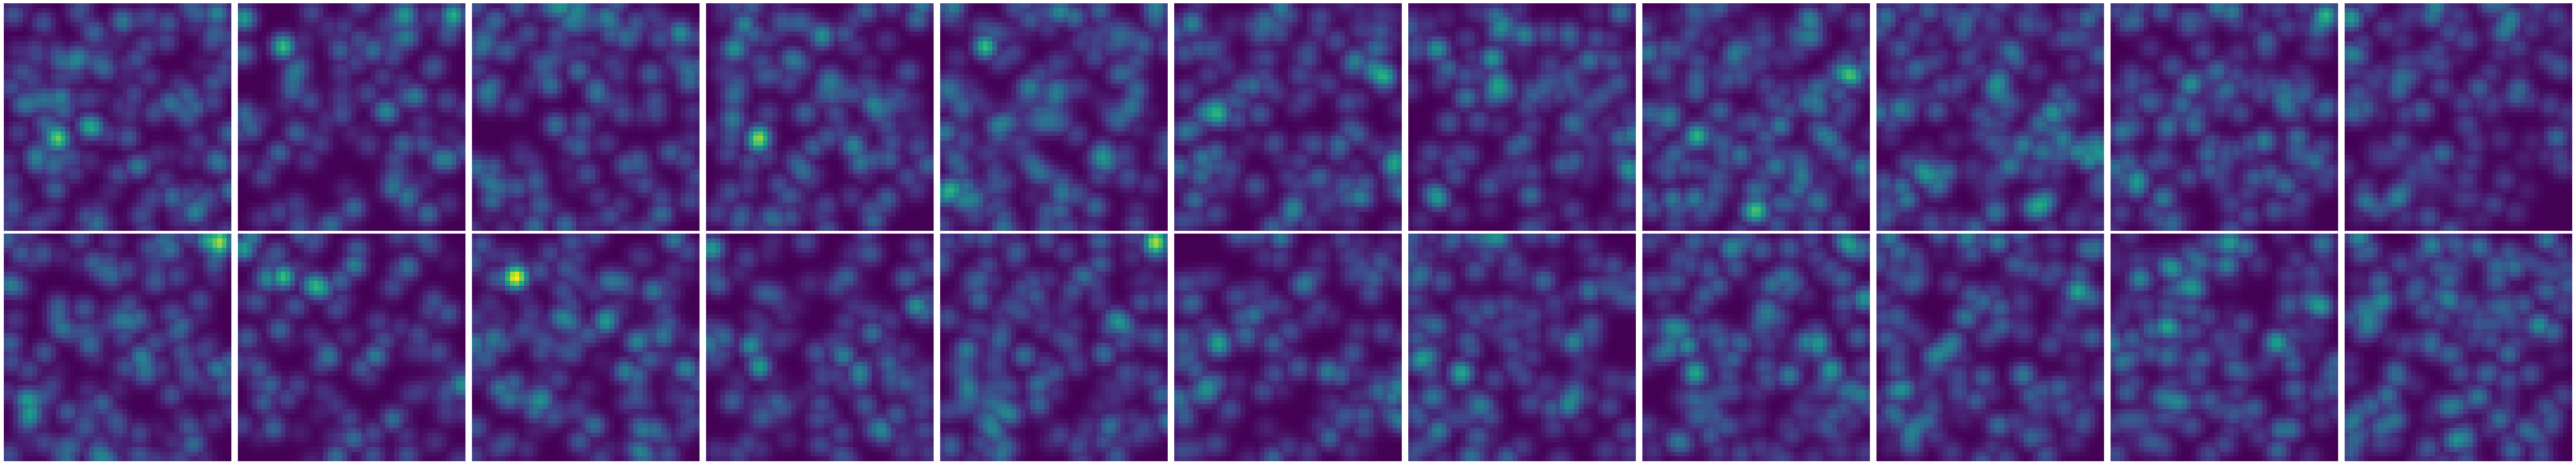

In [ ]:
plot_channels(xsim[0], 2, display=False)

### check that 2D Z reconstruction is correct.

In [ ]:
local_rate = torch.zeros([100,7,11,11]).cuda()
local_rate[:,4,5,5] = 1.

point_process = PointProcessUniform(local_rate =local_rate, int_conc=3, int_rate=1, sim_iters=1, int_loc=1, channels=22, n_bits=4, codebook=torch.tensor(code_ref)[:1], sim_z=True)
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, codes = point_process.sample(from_code_book=True)
df = sample_to_df(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, codes, px_size_zyx=[1,1,1])

x_os_3d *= 0 
y_os_3d *= 0 
ints_3d *= 0 
ints_3d += 1
z_os_3d = torch.linspace(-0.5,0.5,100).cuda()

xsim, psf_s = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, eval_=True, add_noise=False)
# scat_3d_projections(ax, df[df['int_11'] > 1])

# tra = []
# chs = locs_3d[1][::4]
# for i in range(100):
#     tra.append(xsim[i,chs[i]])
    
# plt.plot(cpu(torch.stack(tra))[:,0,5,5])

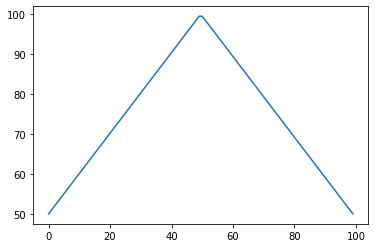

In [ ]:
plt.plot(cpu(xsim)[:,0,4,5,5])
# plt.plot(cpu(xsim)[:,0,4,5,5])
# plt.plot(cpu(xsim)[:,0,2,5,5])

# plt.plot(cpu(xsim)[:,0,2:5,5,5].sum(1))

(<Figure size 750.109x706.909 with 6 Axes>,
 [<AxesSubplot:ylabel='y'>,
  <AxesSubplot:xlabel='x', ylabel='z'>,
  <AxesSubplot:xlabel='z'>])

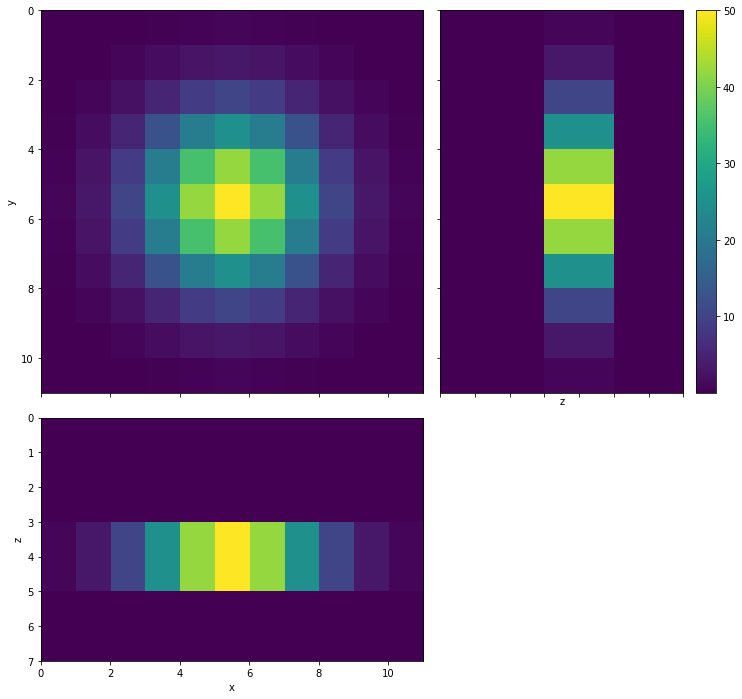

In [ ]:
plot_3d_projections(xsim[0,3])

### Speed Lab

In [ ]:
@script
def _place_psf(psf_vols, b, ch, z, y, x, output_shape):
    '''jit function for placing PSFs
    1) This function will add padding to coordinates (z, y, x) (we need padding in order to place psf on the edges)
    afterwards we will just crop out to original shape
    2) Create empty tensor with paddings loc3d_like
    3) place each individual PSFs in to the corresponding cordinates in loc3d_like
    4) unpad to original output shape

    Args:
        psf_vols:   torch.Tensor
        b:        torch.Tensor
        c:        torch.Tensor
        h:        torch.Tensor
        w:        torch.Tensor
        d:        torch.Tensor
        szs:      torch.Tensor
        
    Shape:
        psf_vols: (Num_E, C, PSF_SZ_X, PSF_SZ_Y, PSF_SZ_Z)
        b:  (Num_E,)
        c:  (Num_E,)
        h:  (Num_E,)
        w:  (Num_E,)
        d:  (Num_E,)
        output_shape:  (BS, Frames, H, W, D)
        
    -Output: placed_psf: (BS, Frames, H, W, D)
        
    '''
    
    psf_b, psf_c, psf_h, psf_w, psf_d = psf_vols.shape
    pad_zyx = [psf_h//2, psf_w//2, psf_d//2]
    #add padding to z, y, x 
    
    z = z + pad_zyx[0]
    y = y + pad_zyx[1]
    x = x + pad_zyx[2]

    #create padded tensor (bs, frame, c, h, w) We will need pad_size * 2 since we are padding from both size
    loc3d_like = torch.zeros(output_shape[0], 
                             output_shape[1], 
                             output_shape[2] + 2*(pad_zyx[0]), 
                             output_shape[3] + 2*(pad_zyx[1]), 
                             output_shape[4] + 2*(pad_zyx[2]), dtype=psf_vols.dtype).to(x.device)
    
    if psf_c == 2:
        psf_ch_ind = torch.where(ch >= 8, 1, 0)
        psf_vols = psf_vols[torch.arange(len(psf_ch_ind)),psf_ch_ind]
    if output_shape[1] == 1:
        ch = torch.zeros_like(ch)
        
    psf_vols = psf_vols.reshape(-1, psf_h, psf_w, psf_d)
    
    # Take limit calculation out of the loop for 30% speed up
    z_l = z - pad_zyx[0]
    y_l = y - pad_zyx[1]
    x_l = x - pad_zyx[2]
    
    z_h = z + pad_zyx[0] + 1
    y_h = y + pad_zyx[1] + 1
    x_h = x + pad_zyx[2] + 1
    
    for idx in range(x.shape[0]):
        loc3d_like[b[idx], ch[idx],
        z_l[idx] : z_h[idx],
        y_l[idx] : y_h[idx],
        x_l[idx] : x_h[idx]] += psf_vols[idx]

#     for bi, chi, zli, zhi, yli, yhi, xli, xhi, psfvi in zip(b, ch, z_l, z_h, y_l, y_h, x_l, x_h, psf_vols):
#         loc3d_like[bi, chi, zli : zhi, yli : yhi, xli : xhi] += psfvi

    b_sz, ch_sz, h_sz, w_sz, d_sz = loc3d_like.shape

    # unpad to original size
    placed_psf = loc3d_like[:, :, pad_zyx[0]: h_sz - pad_zyx[0],
                                  pad_zyx[1]: w_sz - pad_zyx[1],
                                  pad_zyx[2]: d_sz - pad_zyx[2]]
    return placed_psf

In [ ]:
# ch_inds = ints_3d.nonzero(as_tuple=True)
# locs_3d = [l[ch_inds[0]] for l in locs_3d]
# locs_3d.insert(1,ch_inds[1])
# batch, ch, z, y, x = locs_3d

In [ ]:
placed_psf = _place_psf(psf_s[:2000], batch[:2000], ch[:2000], z[:2000], y[:2000], x[:2000], torch.tensor(output_shape))

In [ ]:
for i in range(10):
    placed_psf = _place_psf(psf_s[:2000], batch[:2000], ch[:2000], z[:2000], y[:2000], x[:2000], torch.tensor(output_shape))

In [ ]:
for i in range(10):
    placed_psf = _place_psf(psf_s[:2000], batch[:2000], ch[:2000], z[:2000], y[:2000], x[:2000], torch.tensor(output_shape))

In [ ]:
Last executed 2022-01-05 14:47:01 in 8.31s

In [ ]:
res_dict['Samples_si'] = torch.where(torch.sigmoid(res_dict['logits']) > 0.5, 1, 0)

locations = res_dict['Samples_si'].nonzero(as_tuple=True)

xyzi_ix = [locations[0],locations[2],locations[3], locations[4]]
x_os_3d = res_dict['xyzi_mu'][:,0][xyzi_ix]
y_os_3d = res_dict['xyzi_mu'][:,1][xyzi_ix]
z_os_3d = res_dict['xyzi_mu'][:,2][xyzi_ix]
ints_3d = res_dict['xyzi_mu'][:,3][xyzi_ix]
# output_shape  = res_dict['Samples_si'].shape
x_os_3d = x_os_3d.repeat_interleave(n_bits)
y_os_3d = y_os_3d.repeat_interleave(n_bits)
z_os_3d = z_os_3d.repeat_interleave(n_bits)
ints_3d = ints_3d.repeat_interleave(n_bits)/n_bits

locations = [locations[0].repeat_interleave(n_bits),
             torch.tensor(code_ref)[locations[1]].reshape(-1),
             locations[2].repeat_interleave(n_bits),
             locations[3].repeat_interleave(n_bits), 
             locations[4].repeat_interleave(n_bits)]

NameError: name 'res_dict' is not defined

In [ ]:
torch.sigmoid(res_dict['logits']).max()

tensor(0.0099, grad_fn=<MaxBackward1>)

In [ ]:
def get_micro_inp(res_dict, code_ref, p_si=None, n_bits=4, channels=16):

    res_dict['Samples_si'] = torch.where(torch.sigmoid(res_dict['logits']) > 0.0091, 1, 0)
    # remove dump inds. Wont get reconstructed. 
    locations = res_dict['Samples_si'][:,:-1].nonzero(as_tuple=True)

    xyzi_ix = [locations[0],locations[2],locations[3], locations[4]]
    x_os_3d = res_dict['xyzi_mu'][:,0][xyzi_ix]
    y_os_3d = res_dict['xyzi_mu'][:,1][xyzi_ix]
    z_os_3d = res_dict['xyzi_mu'][:,2][xyzi_ix]
    ints_3d = res_dict['xyzi_mu'][:,3][xyzi_ix]
    # output_shape  = res_dict['Samples_si'].shape
    ints_3d = ints_3d/n_bits+1

    ints_ret = ints_3d[:,None].repeat_interleave(channels, 1)
#     ch_bin = torch.zeros(ints_ret.shape).to(ints_ret.device)
#     ch_bin.scatter_(index=torch.tensor(code_inds).to(ints_ret.device)[locations[1]], dim=1, value=1)
    ch_bin = torch.tensor(code_ref)[locations[1]]
    ints_ret = ints_ret*ch_bin.to(ints_ret.device)

    output_shape  = res_dict['Samples_si'].shape
    output_shape  = torch.Size([output_shape[0],channels,output_shape[2],output_shape[3],output_shape[4]])

    return xyzi_ix, x_os_3d, y_os_3d, z_os_3d, ints_ret, output_shape

In [ ]:
locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape = get_micro_inp(res_dict, torch.tensor(code_ref), p_si=None, n_bits = 4, channels=22)

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
xsim, psf = micro(locs_3d, x_os_3d, y_os_3d, z_os_3d, ints_3d, output_shape, eval_=True, add_noise=True)
fig, ax = plot_3d_projections(xsim[0,5])
# scat_3d_projections(ax, df[df['int_11'] > 1])
xsim.sum()

In [ ]:
len(locs_3d[0])

In [ ]:
from decode_fish.funcs.file_io import load_tiff_image
gt_psf = load_tiff_image('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/figures/PSF_subsampled.tif')[0]
gt_psf /= gt_psf.max()

In [ ]:
# gt_psf = gt_psf.cuda()
gt_psf_mul = torch.cat(100*[gt_psf[None]])
psf_deformed = torch.cat([torch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=0.25).sample([3,3,3,3]).to(gt_psf.device), order=3)[None] for psf in gt_psf_mul])

In [ ]:
# gt_psf = gt_psf.cuda()
gt_psf_mul = torch.cat(100*[gt_psf[None]])
deforms = torch.cuda.FloatTensor(100,3,3,3,3).normal_() * 0.25 # torch.distributions.Normal(loc=0, scale=0.25).sample([100,3,3,3,3])
psf_deformed = torch.cat([etorch.deform_grid(psf, deform, order=3)[None] for psf, deform in zip(gt_psf_mul, deforms)])

In [ ]:
z_os_3d = torch.rand(z_os_3d.shape).to('cuda')

In [ ]:
psf_deformed = etorch.deform_grid(gt_psf_mul, deforms[0],axis=(1,2,3), order=3)

In [ ]:
import elasticdeform.torch as etorch

gt_psf_mul = torch.cat(5*[gt_psf[None]])

psf_deformed = torch.cat([etorch.deform_grid(psf, torch.distributions.Normal(loc=0, scale=0.25).sample([3,3,3,3]).to(gt_psf.device), order=3)[None] for psf in gt_psf_mul])

for i in range(5):
    fig1,_ = plot_3d_projections(gt_psf, display=False)
    fig2,_ = plot_3d_projections(psf_deformed[i], display=False)

    combine_figures([fig1,fig2],[])

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_evaluation.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 20_MERFISH_visualization.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted index.ipynb.
